# Computational Reproducibility of Jupyter Notebooks from Pubmed Central Publications

## General Statistics of the Study

Analyse the metadata collected from Pubmed Central publications that mentions Jupyter notebooks and GitHub.

In [1]:
import sys

sys.path.insert(0, "../archaeology")
sys.path.insert(0, "../analysis")

import importlib
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from db import connect

import analysis_helpers

importlib.reload(analysis_helpers)
from analysis_helpers import var

%matplotlib inline

In [2]:
# Create folder for outputs
OUTPUT_DIR = "Outputs"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Journals

In [3]:
# Get information on journals
with connect() as session:
    journals = pd.read_sql_table("journal", session.connection())

In [4]:
journals.head(5)

,id,name,nlm_ta,iso_abbrev,issn_epub,publisher_name,publisher_loc
0,1,BMC Bioinformatics,BMC Bioinformatics,BMC Bioinformatics,1471-2105,BioMed Central,London
1,2,Journal of Mammary Gland Biology and Neoplasia,J Mammary Gland Biol Neoplasia,J Mammary Gland Biol Neoplasia,1573-7039,Springer US,New York
2,3,The Journal of General Physiology,J Gen Physiol,J Gen Physiol,1540-7748,Rockefeller University Press,None
3,4,Frontiers in Cellular and Infection Microbiology,Front Cell Infect Microbiol,Front Cell Infect Microbiol,2235-2988,Frontiers Media S.A.,None
4,5,eLife,eLife,Elife,2050-084X,"eLife Sciences Publications, Ltd",None


#### Journal Count

In [5]:
# Total Number of Journals
print("Journals: {}".format(var("journals", len(journals), "{:,}")))

Journals: 740


## Articles

In [6]:
# Get information on articles
with connect() as session:
    articles = pd.read_sql_table("article", session.connection())

In [7]:
articles.head(3)

,id,journal_id,name,pmid,pmc,publisher_id,doi,subject,published_date,received_date,accepted_date,license_type,copyright_statement,keywords,repositories
0,1,1,ElasticBLAST: accelerating sequence search via...,NaN,10040096,5245,10.1186/s12859-023-05245-9,Software,2023-03-26,2023-01-04,2023-03-21,None,© This is a U.S. Government work and not under...,BLAST;Cloud computing;Alignment;Kubernetes;AWS...,https://github.com/ncbi/elastic-blast;https://...
1,2,2,Associations Between Dog Breed and Clinical Fe...,36961631.0,10039094,9531,10.1007/s10911-023-09531-3,Original Article,2023-03-24,2022-09-22,2023-02-25,None,© The Author(s) 2023,Canine;Mammary;Adenoma;Carcinoma;Complex;Mixed...,https://github.com/ge8793/Mammary_Public_Data
2,3,3,A cooperative knock-on mechanism underpins Ca,36943243.0,10038842,jgp.202213226,10.1085/jgp.202213226,Article,2023-05-01,2022-07-25,2023-02-28,None,© 2023 Ives et al.,,https://github.com/cmives/Ca_selectivity_mecha...


#### Article Count

In [8]:
# Total Number of Articles
print("Articles: {}".format(var("articles", len(articles), "{:,}")))

Articles: 3,467


## Repositories

In [9]:
# Get information on repositories
with connect() as session:
    repositories = pd.read_sql_table("repositories", session.connection())

In [10]:
repositories.head(3)

,id,article_id,domain,repository,hash_dir1,hash_dir2,commit,notebooks_count,setups_count,requirements_count,notebooks,setups,requirements,processed,pipfiles_count,pipfile_locks_count,pipfiles,pipfile_locks
0,1,1,github.com,ncbi/elastic-blast,98,7dcec6a81a68b9885e96ba7e188c8aec99d86e,eb3575d2fa5a249228678119e9e718b39e5ec1ec,0,1,6,,setup.py,docker-demo/requirements.txt;docker-blast/requ...,8329,0,0,,
1,2,1,github.com,ncbi/blast_plus_docs,af,85c8abfa970b74e5be0d4cb7da57467fb81d0a,a2150a29a5f97f1a6dc65d8e4ca56827bd2cbeae,0,0,0,,,,8329,0,0,,
2,3,1,github.com,ncbi/elastic-blast-demos,db,e656ffaf821bc27abe9b352690487f7eb8085e,3dbc7a3c5a42cd092e4921beffa8250b523cf0e5,1,0,1,elastic-blast-rdrp.ipynb,,requirements.txt,8321,0,0,,


#### Repositories Count

In [11]:
# Total Number of Repositories
print("Repositories: {}".format(var("repositories", len(repositories), "{:,}")))

Repositories: 5,240


## Journals with highest number of articles with mention of Github repository and notebook

In [12]:
# Join journal and article tables
with connect() as session:
    query = """
        SELECT j.name AS journal_name,
               j.nlm_ta,
               j.iso_abbrev
        FROM journal j,
             article a
        WHERE a.journal_id=j.id
    """
    df = pd.read_sql(query, session.connection())
    df["journal_abbrev"] = np.where(df["nlm_ta"] == "", df["iso_abbrev"], df["nlm_ta"])
    df["journal_abbrev"] = np.where(
        df["journal_abbrev"] == "", df["journal_name"], df["journal_abbrev"]
    )
    articles_per_journal = df["journal_abbrev"].value_counts()

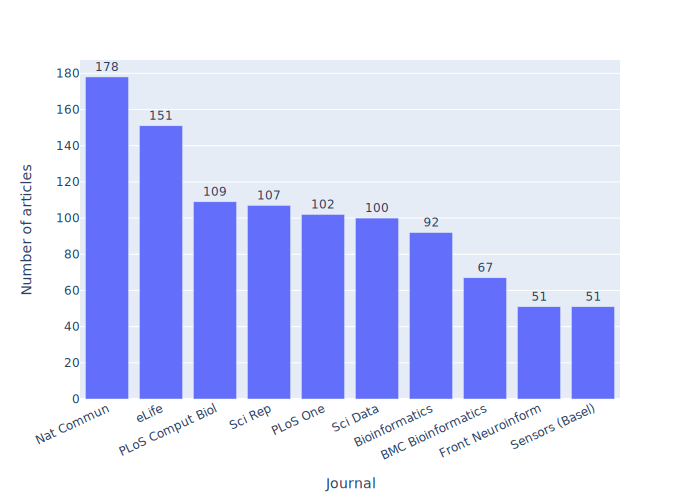

In [13]:
# Articles per Journal
index_label = "Journal"
number_label = "Number of articles"
filename = "Figure_top_journals_with_articles"
articles_per_journal.columns = [index_label, number_label]
articles_per_journal_df = pd.DataFrame(
    {"Journal": articles_per_journal.index, number_label: articles_per_journal.values}
)

fig = px.bar(
    articles_per_journal_df.sort_values(by="Number of articles", ascending=False).head(
        10
    ),
    index_label,
    number_label,
    text=number_label,
)
fig.update_traces(texttemplate="%{text:s}", textposition="outside")
fig.update_layout(uniformtext_minsize=8, uniformtext_mode="hide", xaxis_tickangle=-25)
fig.write_image(OUTPUT_DIR + "/" + filename + ".pdf", scale=1.0)
fig.show("svg")  # Replace it with fig.show() to see the interactive graph

# Journals by number of Github repositories with Jupyter Notebooks

In [14]:
# Join journal, article, and repositories tables
with connect() as session:
    query = """
        SELECT j.name AS journal_name,
               j.nlm_ta,
               j.iso_abbrev,
               r.notebooks_count
        FROM journal j,
             article a,
             repositories r
        WHERE a.journal_id=j.id
          AND a.id=r.article_id
    """
    df = pd.read_sql(query, session.connection())
    df["journal_abbrev"] = np.where(df["nlm_ta"] == "", df["iso_abbrev"], df["nlm_ta"])
    df["journal_abbrev"] = np.where(
        df["journal_abbrev"] == "", df["journal_name"], df["journal_abbrev"]
    )

In [15]:
# Number of repositories per journal
repositories_per_journal_df = df["journal_abbrev"].value_counts().reset_index()
repositories_per_journal_df.columns = ["journal_abbrev", "repositories_count"]
repositories_per_journal_df.head()

,journal_abbrev,repositories_count
0,eLife,384
1,Nat Commun,336
2,PLoS Comput Biol,197
3,Sci Data,186
4,PLoS One,173


In [16]:
# Number of repositories with notebooks per journal
repositories_with_notebooks_per_journal_df = df[df["notebooks_count"] > 0]
repositories_with_notebooks_per_journal_df = (
    repositories_with_notebooks_per_journal_df["journal_abbrev"]
    .value_counts()
    .reset_index()
)
repositories_with_notebooks_per_journal_df.columns = [
    "journal_abbrev",
    "repositories_with_notebooks_count",
]
repositories_with_notebooks_per_journal_df.head()

,journal_abbrev,repositories_with_notebooks_count
0,eLife,212
1,Nat Commun,169
2,Sci Data,111
3,PLoS Comput Biol,103
4,PLoS One,99


In [17]:
# Number of journals with minimum and maximum number of notebooks
min_df = df.groupby("journal_abbrev")["notebooks_count"].min().reset_index()
min_df.columns = ["journal_abbrev", "min_notebooks_count"]
max_df = df.groupby("journal_abbrev")["notebooks_count"].max().reset_index()
max_df.columns = ["journal_abbrev", "max_notebooks_count"]
jounral_min_max_nb_df = pd.merge(min_df, max_df, on="journal_abbrev")
jounral_min_max_nb_df.head()

,journal_abbrev,min_notebooks_count,max_notebooks_count
0,ACS Cent Sci,1,4
1,ACS Energy Lett,3,3
2,ACS Omega,0,12
3,ACS Synth Biol,12,12
4,AI Ethics,14,14


In [18]:
# merge datframes to get journals with repositories and repositories with notebooks
repo_with_without_nb_df = pd.merge(
    repositories_per_journal_df,
    repositories_with_notebooks_per_journal_df,
    on="journal_abbrev",
)
repo_with_without_nb_df.head()

,journal_abbrev,repositories_count,repositories_with_notebooks_count
0,eLife,384,212
1,Nat Commun,336,169
2,PLoS Comput Biol,197,103
3,Sci Data,186,111
4,PLoS One,173,99


In [19]:
# merge datframes to get journals with repositories and repositories with notebooks
# and journals with min and max number of notebooks
repositories_journal_df = pd.merge(
    repo_with_without_nb_df, jounral_min_max_nb_df, on="journal_abbrev"
)
repositories_journal_df.head(10)

,journal_abbrev,repositories_count,repositories_with_notebooks_count,min_notebooks_count,max_notebooks_count
0,eLife,384,212,0,411
1,Nat Commun,336,169,0,260
2,PLoS Comput Biol,197,103,0,115
3,Sci Data,186,111,0,136
4,PLoS One,173,99,0,88
5,BMC Bioinformatics,153,65,0,191
6,Gigascience,139,47,0,79
7,Bioinformatics,136,72,0,38
8,Sci Rep,136,89,0,104
9,Front Neuroinform,114,42,0,38


In [20]:
repositories_journal_df = repositories_journal_df.sort_values(
    by=["repositories_count", "repositories_with_notebooks_count"],
    ascending=[False, False],
)

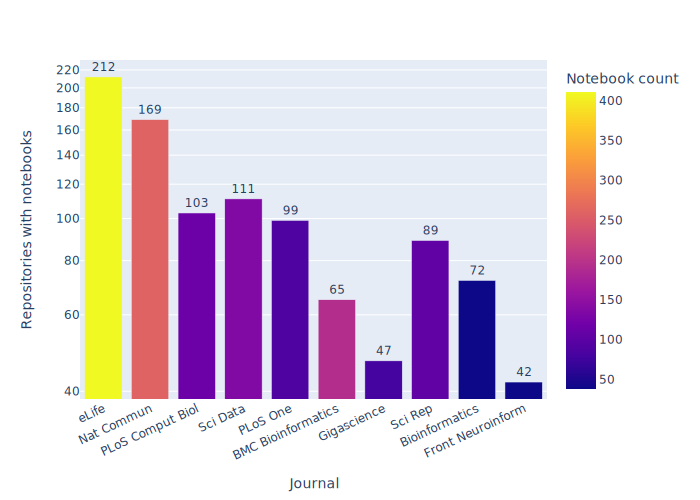

In [21]:
# A bar char for journals with total number of repositories with notebooks
fig = px.bar(
    repositories_journal_df.head(10),
    x="journal_abbrev",
    y="repositories_with_notebooks_count",
    color="max_notebooks_count",
    labels=dict(
        journal_abbrev="Journal",
        repositories_count="Total repositories",
        repositories_with_notebooks_count="Repositories with notebooks",
        min_notebooks_count="Min notebook count",
        max_notebooks_count="Notebook count",
    ),
    hover_data=["repositories_count", "min_notebooks_count"],
)
filename = "Figure_top_journals_with_repositories_notebooks"
fig.update_traces(texttemplate="%{y:s}", textposition="outside")
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode="hide",
    xaxis_tickangle=-25,
    xaxis_title="Journal",
    yaxis_title="Repositories with notebooks",
    yaxis_type="log",
)
fig.write_image(OUTPUT_DIR + "/" + filename + ".pdf", scale=1.0)

fig.show("svg")  # Replace it with fig.show() to see the interactive graph

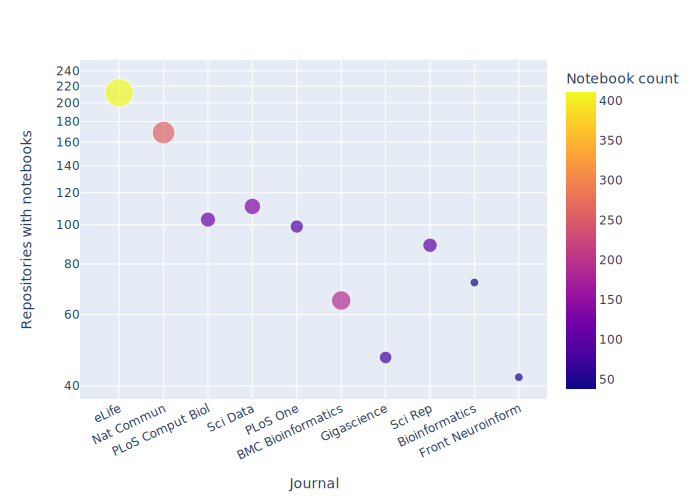

In [22]:
# create scatter plot for journals with total number of repositories with notebooks
fig = px.scatter(
    repositories_journal_df.head(10),
    x="journal_abbrev",
    y="repositories_with_notebooks_count",
    size="max_notebooks_count",
    color="max_notebooks_count",
    labels=dict(
        journal_abbrev="Journal",
        repositories_count="Total repositories",
        repositories_with_notebooks_count="Repositories with notebooks",
        min_notebooks_count="Min notebook count",
        max_notebooks_count="Notebook count",
    ),
    hover_data=["repositories_count", "min_notebooks_count"],
    # title="Top Journals with Repositories and Notebooks",
)
filename = "Figure_top_journals_with_repositories_notebooks_scatter"
fig.update_traces(texttemplate="%{y:s}", textposition="top center")
fig.update_layout(
    xaxis_tickangle=-25,
    xaxis_title="Journal",
    yaxis_title="Repositories with notebooks",
    yaxis_type="log",
)


fig.write_image(OUTPUT_DIR + "/" + filename + ".pdf", scale=1.0)
fig.show("svg")  # Replace it with fig.show() to see the interactive graph

### Journals by the number of GitHub repositories and by the number of GitHub repositories with at least one Jupyter notebook

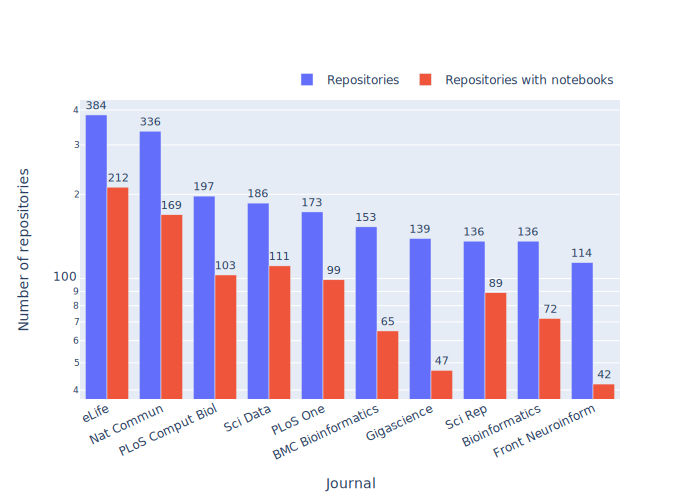

In [23]:
repositories_journal_df = repositories_journal_df.head(10)
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=repositories_journal_df["journal_abbrev"],
        y=repositories_journal_df["repositories_count"],
        name="Repositories",
    )
)
fig.add_trace(
    go.Bar(
        x=repositories_journal_df["journal_abbrev"],
        y=repositories_journal_df["repositories_with_notebooks_count"],
        name="Repositories with notebooks",
    )
)

filename = "Figure_top_journals_repositories_with_without_notebooks"
xaxis_title = "Journal"
yaxis_title = "Number of repositories"
fig.update_traces(texttemplate="%{y:s}", textposition="outside")
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode="hide",
    xaxis_tickangle=-25,
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    yaxis_type="log",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
)
fig.write_image(OUTPUT_DIR + "/" + filename + ".pdf", scale=1.0)

fig.show("svg")  # Replace it with fig.show() to see the interactive graph

## Articles by published year

In [24]:
# Extract data to get articles by published year
with connect() as session:
    query = """
        SELECT j.id AS journal_id,
               j.name AS journal_name,
               j.nlm_ta,
               j.iso_abbrev,
               a.id AS article_id,
               a.name AS article_name,
               a.pmc AS article_pmc,
               a.published_date,
               a.accepted_date,
               a.received_date,
               r.id AS repository_id,
               r.notebooks_count
        FROM journal j,
             article a,
             repositories r
        WHERE a.journal_id=j.id
          AND a.id=r.article_id
    """
    df = pd.read_sql(query, session.connection())
    # Get published year from the date.
    # If published date not available, use accepted or received date
    df["article_date"] = np.where(
        df["published_date"] == "", df["accepted_date"], df["published_date"]
    )
    df["article_date"] = np.where(
        df["article_date"] == "", df["received_date"], df["article_date"]
    )
    df["published_year"] = pd.DatetimeIndex(df["article_date"]).strftime("%Y")
    df["journal_abbrev"] = np.where(df["nlm_ta"] == "", df["iso_abbrev"], df["nlm_ta"])
    df["journal_abbrev"] = np.where(
        df["journal_abbrev"] == "", df["journal_name"], df["journal_abbrev"]
    )

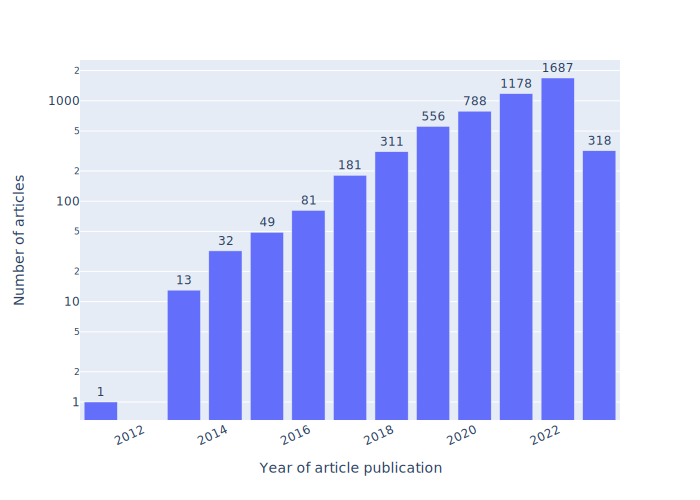

In [25]:
# Articles per year
articles_per_year = df["published_year"].value_counts()
index_label = "Year of article publication"
number_label = "Number of articles"
articles_per_year.columns = [index_label, number_label]
articles_per_year_df = pd.DataFrame(
    {index_label: articles_per_year.index, number_label: articles_per_year.values}
)
filename = "Figure_timeline_articles"
fig = px.bar(articles_per_year_df, index_label, number_label, text=number_label)
fig.update_traces(texttemplate="%{text}", textposition="outside")
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode="hide",
    xaxis_tickangle=-25,
    xaxis_type="date",
    yaxis_type="log",
)
fig.write_image(OUTPUT_DIR + "/" + filename + ".pdf", scale=1.0)
fig.show("svg")  # Replace it with fig.show() to see the interactive graph

## Articles by number of GitHub repositories with at least one Jupyter notebook by year

In [26]:
# Extract the required columns
articles_repos_journal_df = df[
    ["journal_abbrev", "article_pmc", "published_year", "notebooks_count"]
]

articles_per_year_df = articles_repos_journal_df
articles_per_year_df = (
    articles_per_year_df["published_year"].value_counts().reset_index()
)
articles_per_year_df.columns = ["published_year", "articles_count"]
articles_per_year_df.head()

,published_year,articles_count
0,2022,1687
1,2021,1178
2,2020,788
3,2019,556
4,2023,318


In [27]:
# Get articles with notebooks for each year
articles_with_notebooks_per_year_df = df[df["notebooks_count"] > 0]
articles_with_notebooks_per_year_df = (
    articles_with_notebooks_per_year_df["published_year"].value_counts().reset_index()
)
articles_with_notebooks_per_year_df.columns = [
    "published_year",
    "articles_with_notebooks_count",
]
articles_with_notebooks_per_year_df.head()

,published_year,articles_with_notebooks_count
0,2022,833
1,2021,596
2,2020,422
3,2019,273
4,2023,175


In [28]:
# Merge dataframes to get articles and articles with notebooks for each year
article_with_without_nb_df = pd.merge(
    articles_per_year_df, articles_with_notebooks_per_year_df, on="published_year"
)
article_with_without_nb_df.head()

,published_year,articles_count,articles_with_notebooks_count
0,2022,1687,833
1,2021,1178,596
2,2020,788,422
3,2019,556,273
4,2023,318,175


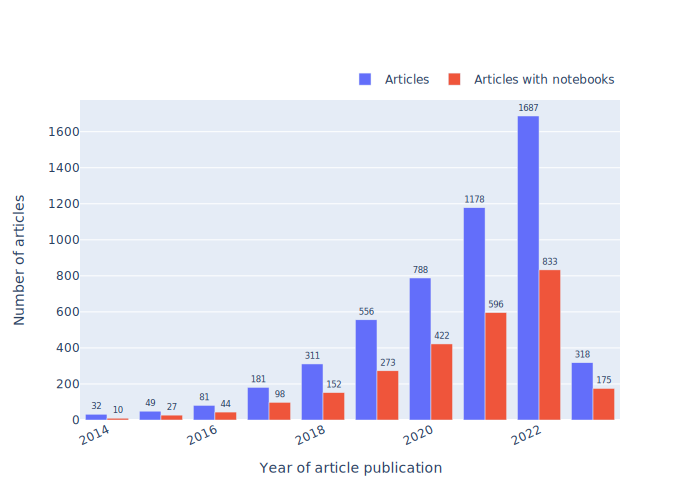

In [29]:
# A timelines of the articles with and without notebooks
article_with_without_nb_df = article_with_without_nb_df.head(10)
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=article_with_without_nb_df["published_year"],
        y=article_with_without_nb_df["articles_count"],
        name="Articles",
    )
)
fig.add_trace(
    go.Bar(
        x=article_with_without_nb_df["published_year"],
        y=article_with_without_nb_df["articles_with_notebooks_count"],
        name="Articles with notebooks",
    )
)

filename = "Figure_timeline_articles_with_without_notebooks"
xaxis_title = "Year of article publication"
yaxis_title = "Number of articles"
fig.update_traces(texttemplate="%{y}", textposition="outside")
fig.update_layout(
    uniformtext_minsize=4,
    uniformtext_mode="hide",
    xaxis_tickangle=-25,
    xaxis_type="date",
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
)
fig.write_image(OUTPUT_DIR + "/" + filename + ".pdf", scale=1.0)
fig.show("svg")  # Replace it with fig.show() to see the interactive graph

## Articles with Author ORCID

In [30]:
# Get autors with ORCID
with connect() as session:
    query = """
        SELECT a.id AS article_id,
               au.id AS author_id,
               au.orcid,
               a.published_date,
               a.name AS article_name,
               au.name AS name,
               au.given_names AS given_names,
               a.accepted_date,
               a.received_date
        FROM article a,
             author au
        WHERE au.article_id=a.id
    """
    df = pd.read_sql(query, session.connection())
    df["article_date"] = np.where(
        df["published_date"] == "", df["accepted_date"], df["published_date"]
    )
    df["article_date"] = np.where(
        df["article_date"] == "", df["received_date"], df["article_date"]
    )
    df["published_year"] = pd.DatetimeIndex(df["article_date"]).strftime("%Y")
    df["author_full_name"] = df["name"] + " " + df["given_names"]

In [31]:
# Get timeline of authors with ORCID
authors_with_orcid_df = (
    df.groupby(["published_year"])["orcid"].size().sort_values(ascending=False)
)
index_label = "Year of article publication"
number_label = "Number of Authors with ORCID"
authors_with_orcid_df.columns = [index_label, number_label]
authors_with_orcid_df.head()

published_year
2022    8559
2021    5962
2020    4099
2019    2879
2023    1976
Name: orcid, dtype: int64

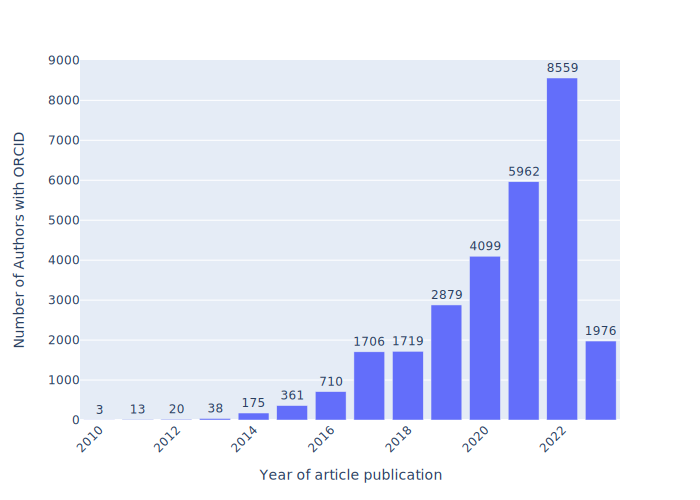

In [32]:
# A timeline of authors with ORCID
newdf = pd.DataFrame(
    {
        index_label: authors_with_orcid_df.index,
        number_label: authors_with_orcid_df.values,
    }
)
newdf.head()
filename = "Figure_timeline_authors_with_orcid"

fig = px.bar(newdf, x=index_label, y=number_label, text=number_label)
fig.update_traces(texttemplate="%{text:.s}", textposition="outside")
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode="hide",
    xaxis_type="date",
    xaxis_tickangle=-45,
)
fig.show("svg")  # Replace it with fig.show() to see the interactive graph
fig.write_image(OUTPUT_DIR + "/" + filename + ".pdf")

In [33]:
notebook_trend_df = pd.merge(
    articles_with_notebooks_per_year_df, authors_with_orcid_df, on="published_year"
)
notebook_trend_df.dropna(inplace=True)
notebook_trend_df.head(10)

,published_year,articles_with_notebooks_count,orcid
0,2022,833,8559
1,2021,596,5962
2,2020,422,4099
3,2019,273,2879
4,2023,175,1976
5,2018,152,1719
6,2017,98,1706
7,2016,44,710
8,2015,27,361
9,2014,10,175


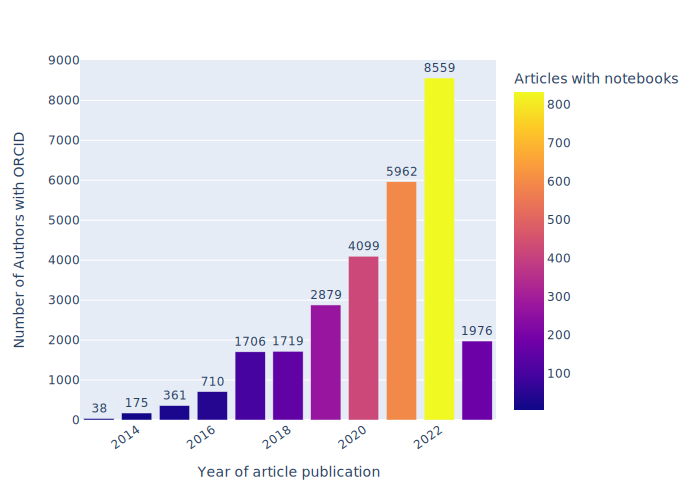

In [34]:
# Timeline of article with notebooks and authors of artciles with ORCID
fig = px.bar(
    notebook_trend_df,
    x="published_year",
    y="orcid",
    color="articles_with_notebooks_count",
    labels=dict(
        published_year="Year of article publication",
        orcid="Number of Authors with ORCID",
        articles_with_notebooks_count="Articles with notebooks",
    ),
)
fig.update_traces(texttemplate="%{y:.s}", textposition="outside")
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode="hide",
    xaxis_type="date",
    xaxis_tickangle=-35,
)
fig.show("svg")  # Replace it with fig.show() to see the interactive graph
filename = "Figure_timeline_articles_authors_with_orcid"
fig.write_image(OUTPUT_DIR + "/" + filename + ".pdf")